<b>Note:</b> This is a testing notebook for LSTM Model.

## Step 1: *Import Libraries*

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from math import sqrt
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM
import plotly.graph_objects as go

## Step 2: *Import Data*

> Data was taken from Yahoo Finance on Gold to USD (XAUT - USD) from 2010 to 2023

In [ ]:
import yfinance as yf
start = '2010-01-01'
end = '2024-01-01'
stock = 'XAUT-USD'
data = yf.download(stock, start, end)
data.reset_index(inplace = True)

[*********************100%%**********************]  1 of 1 completed


## Step 3: Exploratory Data Analysis (EDA)

### Step 3.1: Data Overview

In [ ]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-02-07,1582.213135,1585.620361,1576.241089,1581.786865,1581.786865,1305750
1,2020-02-08,1581.844116,1587.325439,1567.624634,1578.869751,1578.869751,1609288
2,2020-02-09,1578.880005,1590.733154,1572.618164,1578.702271,1578.702271,575041
3,2020-02-10,1579.318970,1594.563721,1560.719360,1572.435547,1572.435547,123025
4,2020-02-11,1572.398926,1617.188721,1546.927002,1563.408325,1563.408325,340994
...,...,...,...,...,...,...,...
1419,2023-12-27,2067.487061,2083.567383,2063.218018,2074.964355,2074.964355,4770225
1420,2023-12-28,2075.123047,2087.295654,2066.581787,2072.599121,2072.599121,4990665
1421,2023-12-29,2072.603760,2078.412354,2060.760742,2068.144775,2068.144775,5308010
1422,2023-12-30,2068.159912,2069.790527,2060.790771,2067.288574,2067.288574,5317621


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1424 entries, 0 to 1423
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1424 non-null   datetime64[ns]
 1   Open       1424 non-null   float64       
 2   High       1424 non-null   float64       
 3   Low        1424 non-null   float64       
 4   Close      1424 non-null   float64       
 5   Adj Close  1424 non-null   float64       
 6   Volume     1424 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 78.0 KB


### Step 3.2: Check for duplicated value in *dataset*

In [ ]:
data.duplicated().sum()

0

### Step 3.3: Check for null value in dataset

In [ ]:
data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

> As you can see, the data is taken from 2020 - 2023 while we try taking it from 2010, this is happening because the data in Yahoo Finance is only available from 2020

## Step 4: Data Processing

>We will be droping both *'Vol.'* and *'Change %'* since we didn't need them.

### Step 4.1: Feature Selection

In [ ]:
data.drop(['Adj Close', 'Volume'], axis = 1, inplace = True)
data.head()

,Date,Open,High,Low,Close
0,2020-02-07,1582.213135,1585.620361,1576.241089,1581.786865
1,2020-02-08,1581.844116,1587.325439,1567.624634,1578.869751
2,2020-02-09,1578.880005,1590.733154,1572.618164,1578.702271
3,2020-02-10,1579.318970,1594.563721,1560.719360,1572.435547
4,2020-02-11,1572.398926,1617.188721,1546.927002,1563.408325


### Step 4.2: Transforming Data Types

> The data is already on a correct data type but incase if you would like to change the data set, this is the code to change the datatype to the corresponding datatype

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values(by = 'Date', ascending =  True, inplace = True)
data.reset_index(drop = True, inplace = True)

> If the data contains ' , ' in the dataset, this is redundant and needed to be remove from the entire dataset. This dataset doesn't need it but below is how you would change them. Thenm, we change the variables to *float64* type

In [ ]:
NumCols = data.columns.drop(['Date'])
data[NumCols] = data[NumCols].replace({',' : ''}, regex = True)
data[NumCols] = data[NumCols].astype('float64')

> ***result :***

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1424 entries, 0 to 1423
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1424 non-null   datetime64[ns]
 1   Open    1424 non-null   float64       
 2   High    1424 non-null   float64       
 3   Low     1424 non-null   float64       
 4   Close   1424 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 55.8 KB


In [ ]:
data.head()

,Date,Open,High,Low,Close
0,2020-02-07,1582.213135,1585.620361,1576.241089,1581.786865
1,2020-02-08,1581.844116,1587.325439,1567.624634,1578.869751
2,2020-02-09,1578.880005,1590.733154,1572.618164,1578.702271
3,2020-02-10,1579.318970,1594.563721,1560.719360,1572.435547
4,2020-02-11,1572.398926,1617.188721,1546.927002,1563.408325


## Step 5: Visualizing Data

In [ ]:
hovertext = []
for i in range(len(data['Open'])):
    hovertext.append('Open: '+str(data['Open'][i])+'<br>Close: '+str(data['Close'][i]))

fig = go.Figure(data=go.Ohlc(x=data['Date'],
                    open=data['Open'],
                    high=data['High'],
                    low=data['Low'],
                    close=data['Close'],
                    text = hovertext,
                    hoverinfo = 'text'))
fig.show()

## Step 6: Splitting Data to Training & Test Sets

> Since we are using LSTM, which is a time-series model, we should not randomly split the data. In time-series splitting, testing set is always later than training set. As consideration, we followed the author using the last year for test set and the rest for training.

In [ ]:
test_size = data[data.Date.dt.year == 2022].shape[0]
test_size

365

> Let's plot the training and testing set

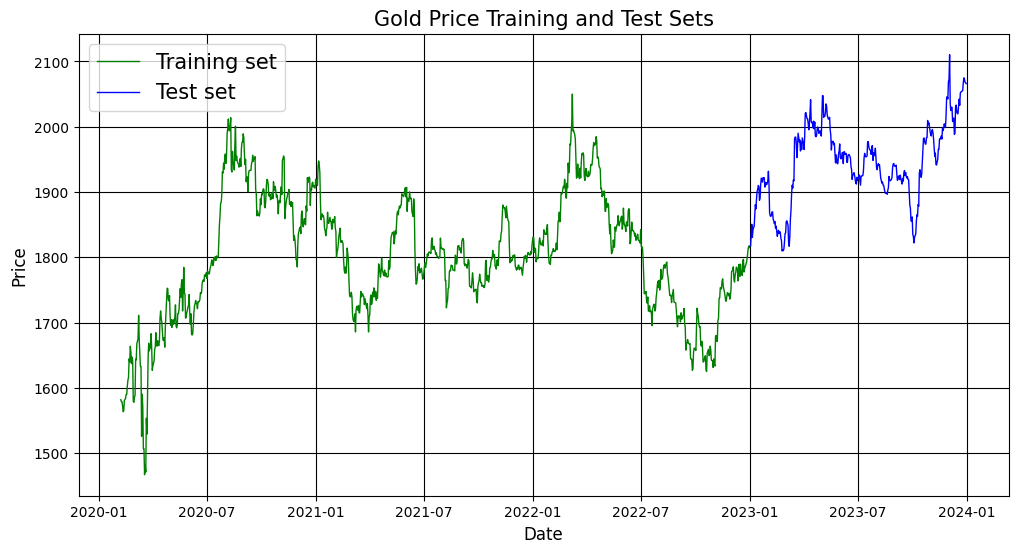

In [ ]:
plt.figure(figsize=(12, 6), dpi=100)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='black')
plt.plot(data.Date[:-test_size], data.Close[:-test_size], color='green', lw=1)
plt.plot(data.Date[-test_size:], data.Close[-test_size:], color='blue', lw=1)
plt.title('Gold Price Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='black')
plt.show()

## Step 7: Data Scaling

> To avoid intensive computation, the author used MinMaxScaler, so first we create the scaling variable *scaler* to fit to our data <br>(**No we do not scaled the data before splitting them**)<br>$𝑋scaled = \frac{𝑋 - 𝑋min}{𝑋max - 𝑋min}$

In [ ]:
scaler = MinMaxScaler()
scaler.fit(data.Close.values.reshape(-1, 1))

MinMaxScaler()

## Step 8: Restructure Data & Create Sliding Window

>
```
Sliding window = the use of prior time step to predict the next time step<br>
Window width = the number of previous time steps<br><br>
```
>In this way, we can express time series data as supervised learning. We can do this by using previous time steps as input variables and the next time steps as output variable. The window width used by the author is 60, which mean the X_train and X_test will be nested list containing lists of 60 time-stamp prices. y_train and y_test are also lists of gold prices containing the next day's gold price corresponds to each list in X_train and X_test respectively.

In [ ]:
window_size = 60

### Training Set

In [ ]:
train_data = data.Close[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1, 1)) # Perform Scaling on train set

X_train = []
y_train = []

for i in range(window_size, len(train_data)):
  X_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])

### Test Set

In [ ]:
test_data = data.Close[-test_size-60:]
test_data = scaler.transform(test_data.values.reshape(-1, 1)) # Perform Scaling on test set

X_test = []
y_test = []

for i in range(window_size, len(test_data)):
  X_test.append(test_data[i-60:i, 0])
  y_test.append(test_data[i, 0])

## Step 9: Converting Data to Numpy Arrays

> Now X_train and X_test are nested lists (two-dimensional lists) and y_train and y_test is a one-dimensional list. We need to convert them to numpy arrays with a higher dimension, which is the data format accepted by TensorFlow when training the neural network

In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1, 1))
y_test = np.reshape(y_test, (-1,1))

In [ ]:
print('X_train Shape: ', X_train.shape)
print('X_test Shape: ', X_test.shape)
print('y_train Shape: ', y_train.shape)
print('y_test Shape: ', y_test.shape)

X_train Shape:  (999, 60, 1)
X_test Shape:  (365, 60, 1)
y_train Shape:  (999, 1)
y_test Shape:  (365, 1)


## Step 10: Creating a LSTM Network

> model definition:

In [ ]:
def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 64, return_sequences=True)(input1)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()

    return model

In [ ]:
model = []

In [ ]:
model = define_model()
history = model.fit(X_train, y_train, epochs=150, batch_size=32,
                    validation_split=0.1, verbose=1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 60, 64)            16896     
                                                                 
 dropout (Dropout)           (None, 60, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0     

## Step 11: Model Evaluation

In [ ]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

12/12 [==============================] - 1s 6ms/step


In [ ]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE

In [ ]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: 0.0014361219946295023
Test MAPE: 0.04262670924227936
Test Accuracy: 0.9573732907577206


In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score
print("LSTM Error Metrics:\n")
# MAE LSTM
mae = mean_absolute_error(y_test, y_pred)
print("MAE: ", mae)

# MSE LSTM
mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)

# MAPE LSTM
MAPE = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE: ", MAPE)

# RMSE LSTM
rmse = sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: ", rmse)

# R-squared Error
r2 = r2_score(y_test, y_pred)
print("R2_score: ", r2)

LSTM Error Metrics:

MAE:  0.03236193065929857
MSE:  0.0014361220437551076
MAPE:  0.04262670924227936
RMSE:  0.03789620091453901
R2_score:  0.8420857822427019


In [ ]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

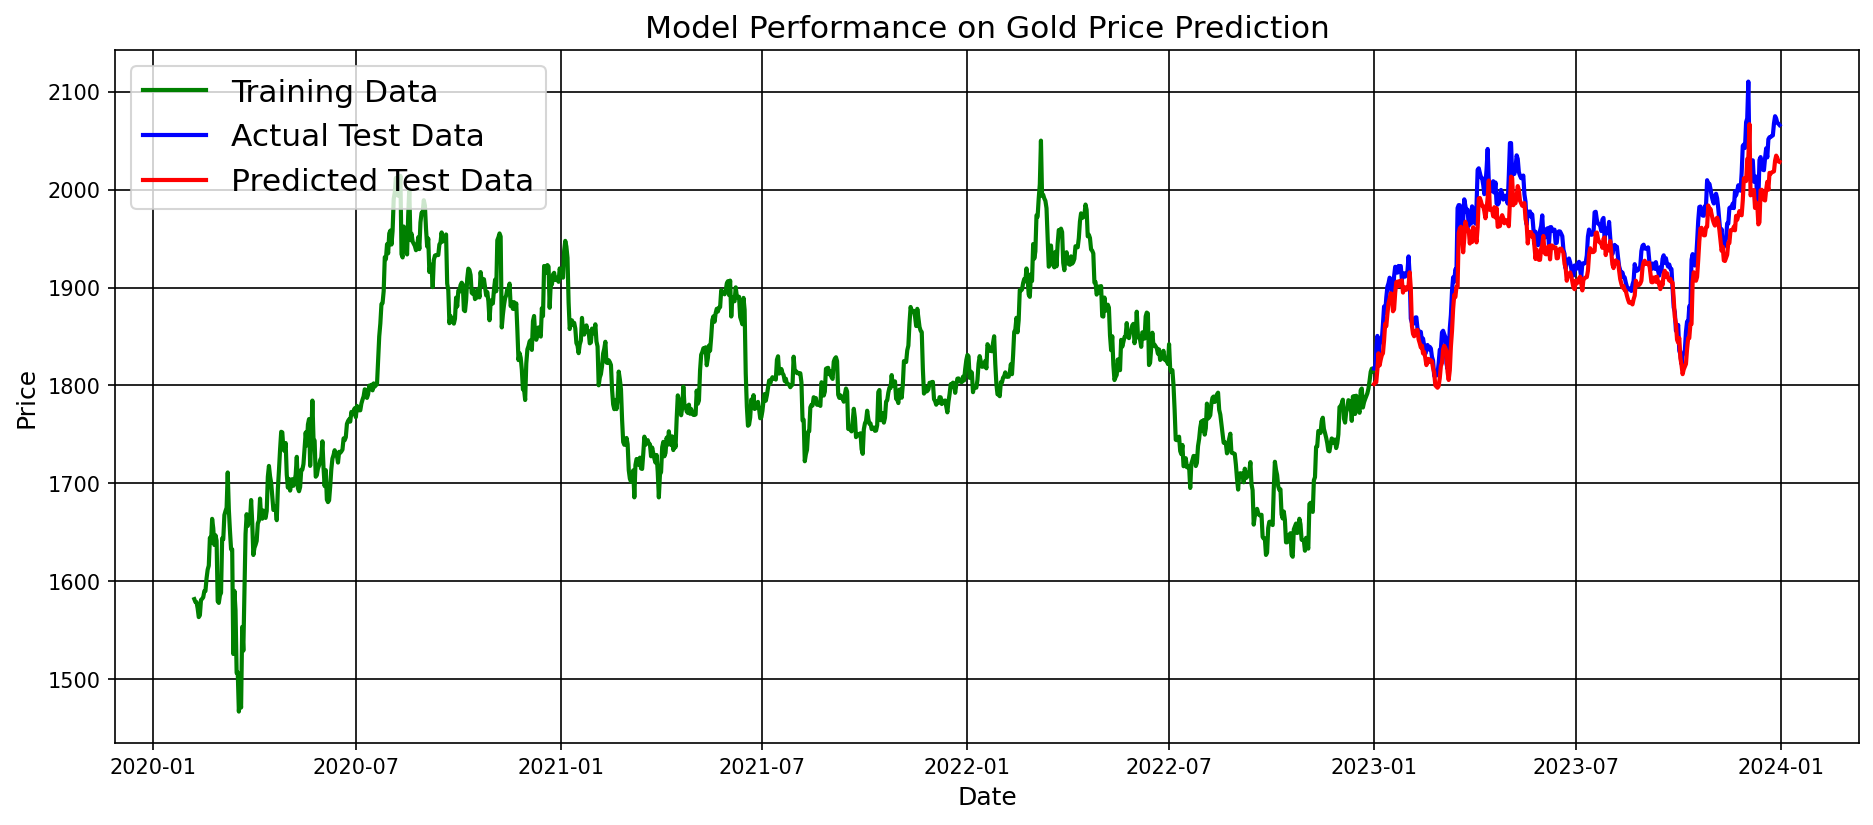

In [ ]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='black')
plt.plot(data['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='green', lw=2)
plt.plot(data['Date'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(data['Date'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Model Performance on Gold Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='black')
plt.show()

In [ ]:
from google.colab import files
model.save('Gold-price-prediction.keras')

## Gated Recurrent Unit (GRU) Comparison

In [ ]:
from keras.layers import Dense, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
from keras.models import Sequential

In [ ]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50
7/7 [==============================] - 6s 21ms/step - loss: 0.1248
Epoch 2/50
7/7 [==============================] - 0s 19ms/step - loss: 0.0734
Epoch 3/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0428
Epoch 4/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0233
Epoch 5/50
7/7 [==============================] - 0s 15ms/step - loss: 0.0213
Epoch 6/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0185
Epoch 7/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0162
Epoch 8/50
7/7 [==============================] - 0s 12ms/step - loss: 0.0156
Epoch 9/50
7/7 [==============================] - 0s 12ms/step - loss: 0.0152
Epoch 10/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0153
Epoch 11/50
7/7 [==============================] - 0s 12ms/step - loss: 0.0140
Epoch 12/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0143
Epoch 13/50
7/7 [==============================] - 0s 14ms/st

In [ ]:
GRU_predicted_stock_price = regressorGRU.predict(X_test)

12/12 [==============================] - 1s 6ms/step


In [ ]:
gru_rmse = sqrt(mean_squared_error(y_test, GRU_predicted_stock_price))
gru_mae = mean_absolute_error(y_test, GRU_predicted_stock_price)
gru_mape = mean_absolute_percentage_error(y_test, GRU_predicted_stock_price)
gru_r2 = r2_score(y_test, GRU_predicted_stock_price)
gru_mse = mean_squared_error(y_test, GRU_predicted_stock_price)

print(f"GRU Error Metrics:\n")

print("GRU MAE: ", gru_mae)
print("GRU MSE: ", gru_mse)
print("GRU MAPE: ", gru_mape)
print("GRU RMSE: ", gru_rmse)
print("GRU R2_score: ", gru_r2)

GRU Error Metrics:

GRU MAE:  0.03697160872388221
GRU MSE:  0.002245392433301976
GRU MAPE:  0.049387076973315375
GRU RMSE:  0.04738557199509125
GRU R2_score:  0.7530994032123487


## Recurrent Neural Network (RNN) Comparison

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80, verbose=1, mode='min')
callbacks_list = [earlystop]

In [ ]:
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras import optimizers

hl = [50, 45]

# Build and train the model
def fit_model(X_train, y_train, X_val, y_val, hl,):
    model_RNN = Sequential()
    model_RNN.add(SimpleRNN(hl[0], input_shape=(60, 1), return_sequences=True, activation='relu'))
    for units in hl[1:]:
        model_RNN.add(SimpleRNN(units, activation='relu', return_sequences=True))
    model_RNN.add(SimpleRNN(hl[-1], activation='relu'))
    model_RNN.add(Dense(1))

    model_RNN.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss='mean_squared_error')

    history = model_RNN.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val, y_val), verbose=1, shuffle=False, callbacks=callbacks_list)
    model_RNN.reset_states()
    return model_RNN, history.history['loss'], history.history['val_loss']

val_size = int(0.1 * len(X_train))
X_val, y_val = X_train[-val_size:], y_train[-val_size:]
X_train, y_train = X_train[:-val_size], y_train[:-val_size]
model_RNN, train_error, val_error = fit_model(X_train, y_train, X_val, y_val, hl)

Epoch 1/200
29/29 [==============================] - 7s 146ms/step - loss: 0.0184 - val_loss: 0.0026
Epoch 2/200
29/29 [==============================] - 6s 213ms/step - loss: 0.0058 - val_loss: 0.0025
Epoch 3/200
29/29 [==============================] - 4s 135ms/step - loss: 0.0060 - val_loss: 0.0014
Epoch 4/200
29/29 [==============================] - 6s 216ms/step - loss: 0.0054 - val_loss: 0.0017
Epoch 5/200
29/29 [==============================] - 4s 144ms/step - loss: 0.0029 - val_loss: 0.0011
Epoch 6/200
29/29 [==============================] - 4s 132ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 7/200
29/29 [==============================] - 5s 179ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 8/200
29/29 [==============================] - 4s 140ms/step - loss: 0.0029 - val_loss: 0.0010
Epoch 9/200
29/29 [==============================] - 4s 132ms/step - loss: 0.0020 - val_loss: 8.1142e-04
Epoch 10/200
29/29 [==============================] - 5s 188ms/step - loss: 0.0014 - va

In [ ]:
y_rnn = model_RNN.predict(X_test)
rnn_rmse = sqrt(mean_squared_error(y_test, y_rnn))
rnn_mae = mean_absolute_error(y_test, y_rnn)
rnn_mape = mean_absolute_percentage_error(y_test, y_rnn)
rnn_r2 = r2_score(y_test, y_rnn)
rnn_mse = mean_squared_error(y_test, y_rnn)

print(f"GRU Error Metrics:\n")

print("GRU MAE: ", rnn_mae)
print("GRU MSE: ", rnn_mse)
print("GRU MAPE: ", rnn_mape)
print("GRU RMSE: ", rnn_rmse)
print("GRU R2_score: ", rnn_r2)

12/12 [==============================] - 1s 16ms/step
GRU Error Metrics:

GRU MAE:  0.020059770131863
GRU MSE:  0.0006400301763106723
GRU MAPE:  0.026665565239009942
GRU RMSE:  0.025298817686023833
GRU R2_score:  0.9296230671531979


## Model Comparison

In [ ]:
metrics_dict = {'Model': [], 'MAE': [], 'MSE': [], 'MAPE': [], 'RMSE': [], 'r2': []}
models = [model, regressorGRU, model_RNN]
model_names = ['LSTM', 'GRU', 'RNN']

In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r_squared = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    return mse, rmse, mae, r_squared, mape, y_test, y_pred

In [ ]:
def plot_data(Y_test, Y_hat, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(Y_test, color='r')
    plt.plot(Y_hat, color='y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title(f"Stock Price Prediction using {model_name}")
    plt.legend(['Actual', 'Predicted'], loc='lower right')
    plt.show()

12/12 [==============================] - 0s 6ms/step


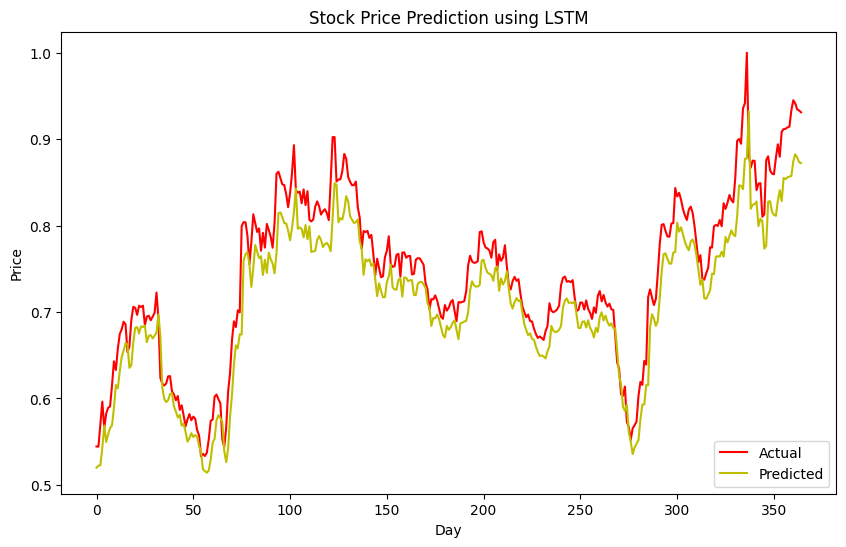

12/12 [==============================] - 0s 7ms/step


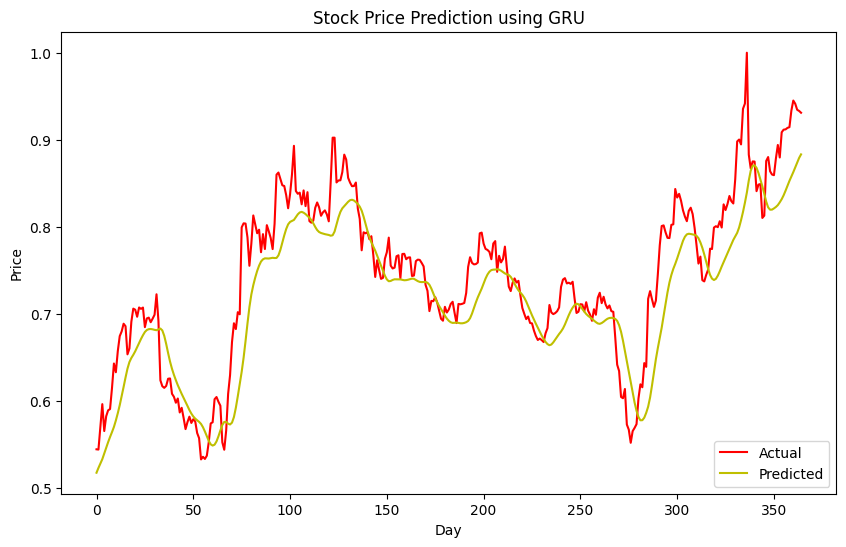

12/12 [==============================] - 0s 18ms/step


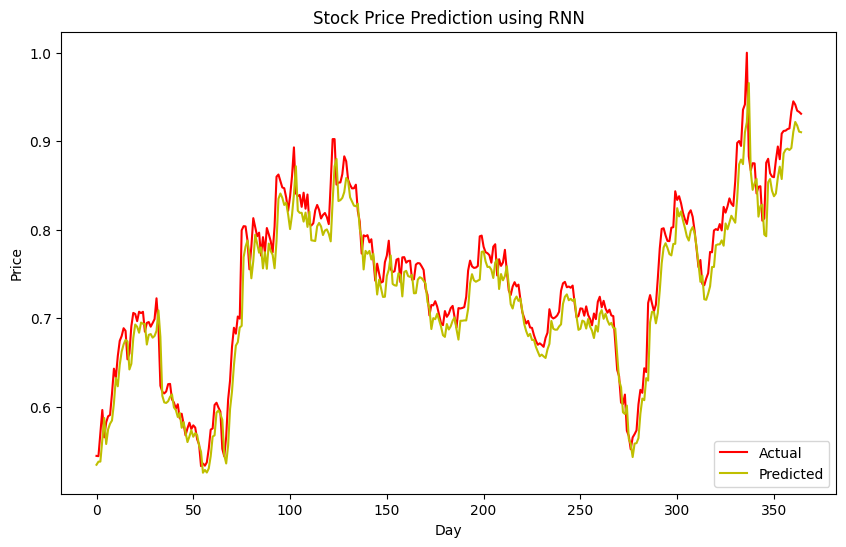

In [ ]:
for model, name in zip(models, model_names):
    mse, rmse, mae, r_squared, mape, true, predicted = evaluate_model(model, X_test, y_test)

    metrics_dict['Model'].append(name)
    metrics_dict['MAE'].append(mae)
    metrics_dict['MSE'].append(mse)
    metrics_dict['MAPE'].append(mape)
    metrics_dict['RMSE'].append(rmse)
    metrics_dict['r2'].append(r_squared)

    plot_data(true, predicted, name)

In [ ]:
metrics_df = pd.DataFrame(metrics_dict)
metrics_df.style.format({'MAE': '{:.3f}', 'MSE': '{:.3f}', 'MAPE': '{:.3f}', 'RMSE': '{:.3f}', 'r2': '{:.3f}'}).highlight_min(color='green', subset=['MAE', 'MSE', 'MAPE', 'RMSE']).highlight_max(color='green', subset=['r2'])


,Model,MAE,MSE,MAPE,RMSE,r2
0,LSTM,0.032,0.001,0.043,0.038,0.842
1,GRU,0.037,0.002,0.049,0.047,0.753
2,RNN,0.020,0.001,0.027,0.025,0.930
